## Conformer Generation in RDKit

Molecules are usually drawn as flat, 2D structures but they actually exist in
3D! In order to generate these 3D coordinates, we need a physics-based method to
evaluate the energy of conformers and optimize their geometries.

Luckily, RDKit contains an open-source implementation of MMFF94 (Merck Molecular
Force Field) which can optimize the geometry of conformers to minimize their
energies. It also uses the ETKDG (Experimental-Torsion basic Knowledge Distance
Geometry) algorithm to generate starting conformers.

In [1]:
from rdkit import Chem
from rdkit.Chem import (
    rdMolDescriptors,
    rdDistGeom,
    AllChem,
    Lipinski,
)
import py3Dmol

# these options customize how our molecules will look when displayed
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (300,200)
IPythonConsole.ipython_useSVG = True
IPythonConsole.drawOptions.addAtomIndices=False
IPythonConsole.drawOptions.addStereoAnnotation=True
IPythonConsole.drawOptions.baseFontSize=0.7
IPythonConsole.drawOptions.annotationFontScale=1
IPythonConsole.drawOptions.fixedBondLength=20

# these options suppress RDKit errors
from rdkit import RDLogger
rdlogger = RDLogger.logger()
rdlogger.setLevel(RDLogger.CRITICAL)

### Utils

We will use these functions for visualization of our molecules. However I will
not explain them in detail in this notebook.

In [2]:
def remove_nonpolar_hs(input_mol: Chem.rdchem.Mol) -> Chem.rdchem.Mol:
    """Remove nonpolar hydrogen atoms.

    Finds all hydrogens bonded to carbon atoms and returns an RDKit Mol object
    with these hydrogens removed.

    Examples
    --------
    mol = Chem.MolFromSmiles('OCCCO')
    mol_polar_h = remove_nonpolar_hs(mol)

    Parameters
    ----------
    input_mol: `rdkit.Chem.rdchem.Mol`
        The input RDKit mol object.

    Returns
    -------
    `rdkit.Chem.rdchem.Mol`
        An RDKit Mol object with all nonpolar hydrogens removed."""
    # Make a copy of input mol.
    mol = Chem.rdchem.Mol(input_mol)

    # Find indices of all hydrogens bonded to carbons.
    nonpolar_hs = []
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 6:
            for n in atom.GetNeighbors():
                if n.GetAtomicNum() == 1:
                    nonpolar_hs.append(n.GetIdx())
    # The list needs to be ordered from high-to-low to avoid indexing issues.
    nonpolar_hs = sorted(nonpolar_hs, reverse=True)

    # We create a Read/Write Mol and remove the nonpolar hydrogens.
    rwmol = Chem.rdchem.RWMol(mol)
    for h in nonpolar_hs:
        rwmol.RemoveAtom(h)

    return rwmol.GetMol()

def display_3d_mol(
    mol: Chem.rdchem.Mol,
    nonpolar_h: bool = False,
    carbon_color: str = 'random',
) -> None:
    """Use py3Dmol to visualize mol in 3D.

    Examples
    --------
    mol = Chem.MolFromSmiles('OCCCO')
    mol = get_low_energy_conformer(mol)
    display_3d_mol(mol)

    Parameters
    ----------
    mol: `rdkit.Chem.rdchem.Mol`
        The input RDKit mol object with an embedded 3D conformer.
    nonpolar_h: `bool`, default = False
        Whether or not to show nonpolar (C-H) hydrogens"""
    from random import choice
    
    mol_block = ''
    if nonpolar_h:
        mol_block = Chem.rdmolfiles.MolToMolBlock(mol, includeStereo=True)
    else:
        mol_block = Chem.rdmolfiles.MolToMolBlock(remove_nonpolar_hs(mol),
                                                  includeStereo=True)
    if carbon_color == 'random':
        carbon_color = choice([
            'white', 'pink', 'cyan', 'green', 'magenta', 'yellow', 'orange'
        ])
    elif carbon_color in [
        'white', 'pink', 'cyan', 'green', 'magenta', 'yellow', 'orange'
    ]:
        pass
    else:
        raise ValueError(f'{carbon_color} is not a valid color')
    view = py3Dmol.view(data=mol_block,
                        width=400,
                        height=300,
                        style={
                            'stick': {
                                'colorscheme': f'{carbon_color}Carbon',
                                'radius':0.25
                            }
                        })
    view.setViewStyle({'style':'outline','color':carbon_color,'width':0.04})
    view.setBackgroundColor('#111111')
    view.show()

### Walking through a conformer generation workflow

The steps in conformer generation are:
* create your Mol *with Hs*
* generate conformers with RDKit's ETKDG
* optimize conformers with MMFF
* find the lowest energy conformer

In this first cell, we create an RDKit Mol from a SMILES string and create two
derivative Mols, mol_h and low_e_mol. mol_h is a copy of mol that has Hs and
we will carry out most operations on mol_h. We also create a copy of mol_h,
low_e_mol, that we will leave clean. At the end, when we have our final low
energy conformer, we will attach it to low_e_mol.

Dotinurad, C14H9Cl2NO4S, used to treat gout
-------------------------------------------


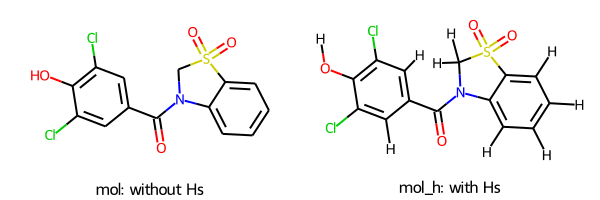

In [3]:
print('Dotinurad, C14H9Cl2NO4S, used to treat gout')
print('-------------------------------------------')
smi = 'C1N(C2=CC=CC=C2S1(=O)=O)C(=O)C3=CC(=C(C(=C3)Cl)O)Cl'
mol = Chem.MolFromSmiles(smi)
# we have to explicitly generate the 2D coordinates in order to align the two
#  2D substructures
# aligning the structures is not necessary but it's certainly nice
AllChem.Compute2DCoords(mol)

mol_h = Chem.AddHs(mol)
# low_e_mol will be the Mol we keep at the end
low_e_mol = Chem.rdchem.Mol(mol_h, True)
# this function tries to align the 2D coordinates of mol_h onto mol
AllChem.GenerateDepictionMatching2DStructure(mol_h, mol)
Chem.Draw.MolsToGridImage(
    mols=[mol,mol_h],
    molsPerRow=2,
    subImgSize=(300,200),
    legends=['mol: without Hs', 'mol_h: with Hs'],
    useSVG=True,
)

The major factor affecting the conformational complexity of a molecule is the
number of rotatable bonds it contains. Thus, we want the number of conformers
we generate to depend on the number of rotatable bonds.

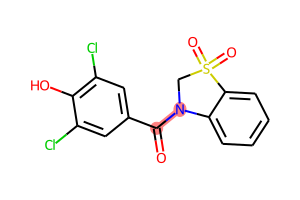

this molecule contains 1 rotatable bond(s)
12 conformers were generated
here is one of the conformers


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [4]:
n_rot_bonds = rdMolDescriptors.CalcNumRotatableBonds(mol)
# by finding the substructure match, RDKit's display utilities will automati-
#  cally highlight the relevant atoms
mol.GetSubstructMatch(Lipinski.RotatableBondSmarts)
display(mol)
print(f'this molecule contains {n_rot_bonds} rotatable bond(s)')

# this is the latest set of parameters for the ETKDG algorithm
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 42
ps.pruneRmsThresh = 0.5
if n_rot_bonds <= 6:
    rdDistGeom.EmbedMultipleConfs(mol_h, 50, ps)
elif n_rot_bonds > 6 and n_rot_bonds <= 10:
    rdDistGeom.EmbedMultipleConfs(mol_h, 200, ps)

print(f'{len(mol_h.GetConformers())} conformers were generated')
print('here is one of the conformers')
display_3d_mol(mol_h, True)

Now we will use MMFF to optimize all the conformers, this is typically the slowest step.

In [5]:
# maxIters is the maximum number of optimization steps MMFF will use before it
#  gives up
opt = AllChem.MMFFOptimizeMoleculeConfs(mol_h, maxIters=200)
# each optimization record is a tuple where the first element is 0 if it
#  succeeded and 1 if it failed. the second element is the MMFF94 energy of the
#  conformer.
display(opt[0:5])

[(0, 84.18894954769556),
 (0, 84.00426275422763),
 (0, 84.00426266041437),
 (0, 83.84912661539475),
 (0, 83.84912669066979)]

Last, we need to find the lowest energy conformer.

In [6]:
# remove conformers that failed to converge, in this case all conformers were
#  successfully optimized
conformers = []
energies = []
for i, tup in enumerate(opt):
    if tup[0] == 0:
        conformers.append(mol_h.GetConformer(i))
        energies.append(tup[1])

# sorts conformers and energies together on the energies
energies, conformers = zip(*sorted(zip(energies, conformers)))

low_e_mol.AddConformer(conformers[0])
display_3d_mol(low_e_mol)
print('the lowest energy conformer')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

the lowest energy conformer


In [7]:
# here we can take a look at the five lowest energy conformers
# overall, we can see that the molecule is rigid which fits our expectations
for i in range(4):
    display_mol = Chem.rdchem.Mol(mol_h, True)
    display_mol.AddConformer(conformers[i])
    display_3d_mol(display_mol)
    print(f'relative energy of conformer is {energies[i] - energies[0]}')
    print('----------------------------------------------')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

relative energy of conformer is 0.0
----------------------------------------------


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

relative energy of conformer is 2.718024916248396e-09
----------------------------------------------


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

relative energy of conformer is 5.1833808356605005e-08
----------------------------------------------


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

relative energy of conformer is 7.527503953497217e-08
----------------------------------------------


### Putting it all together

Now that we understand each component of the workflow, we can write a function
for us to use later that will let us easily access low energy conformers.

In [8]:
from typing import Union


def get_low_energy_conformer(
    input_mol: Union[str, Chem.rdchem.Mol],
    max_iters: int = 200,
    allow_more_rot_bonds: bool = False,
) -> Chem.rdchem.Mol:
    """
    Obtain the lowest energy conformer.

    Finds the MMFF low-energy conformer. It generates n conformers, where n
    depends on the number of rotatable bonds. Then the conformers are optimized
    with the MMFF forcefield. Finally, the lowest energy conformer is returned.
    Will raise error if the number of rotatable bonds is greater than 10.

    Examples
    --------
    mol = Chem.MolFromSmiles('OCCCO')
    low_e_mol = get_low_energy_conformer(mol)

    Parameters
    ----------
    input_mol: `rdkit.Chem.rdchem.Mol`
        The input RDKit mol object.
    max_iters: `int`, default = 200
        The number of iterations allowed for the MMFF optimization.
    allow_more_rot_bonds: bool, default=False
        Flag to allow more than 10 rotatable bonds. Compounds with many
        rotatable bonds have a high chance of failure.

    Returns
    -------
    `rdkit.Chem.rdchem.Mol`
        An RDKit Mol object embedded with the (hopefully) lowest energy
        conformer
    """
    if type(input_mol) == str:
        try:
            mol = Chem.MolFromSmiles(input_mol)
        except ValueError as err:
            print(err)
            raise
    elif type(input_mol) == Chem.rdchem.Mol:
        # create a quickCopy of a Mol which removes all conformers/properties
        mol = Chem.rdchem.Mol(input_mol, True)
    else:
        raise TypeError('expected SMILES string or RDKit Mol')
    mol = Chem.AddHs(mol)
    # we will later return low_e_mol
    low_e_mol = Chem.rdchem.Mol(mol)

    # this count of rotatable bonds INCLUDES amides
    n_rot_bonds = rdMolDescriptors.CalcNumRotatableBonds(mol)
    # this is the latest set of parameters for the ETKDG algorithm
    ps = rdDistGeom.ETKDGv3()
    ps.randomSeed = 42
    ps.pruneRmsThresh = 0.5
    # we create 100 conformers for 0-4 rotatable bonds, 200 conformers for 5-7
    #  rotatable bonds, 300 conformers for 8-10 rotatablebonds, and if allowed,
    #  500 conformers for >10 rotatable bonds
    if n_rot_bonds <= 4:
        rdDistGeom.EmbedMultipleConfs(mol, 100, ps)
    elif n_rot_bonds > 4 and n_rot_bonds <= 7:
        rdDistGeom.EmbedMultipleConfs(mol, 200, ps)
    elif n_rot_bonds > 7 and n_rot_bonds <= 10:
        rdDistGeom.EmbedMultipleConfs(mol, 300, ps)
    elif n_rot_bonds > 10 and allow_more_rot_bonds:
        rdDistGeom.EmbedMultipleConfs(mol, 500, ps)
    elif n_rot_bonds > 10 and not allow_more_rot_bonds:
        raise ValueError('compounds contains greater than 10 rotatable bonds, '
                         'set allow_more_rot_bonds = True')
    
    tuple_success_energy = AllChem.MMFFOptimizeMoleculeConfs(mol)
    # here we unpack our results
    conformers = []
    energies = []
    for i, tup in enumerate(tuple_success_energy):
        if tup[0] == 0:
            conformers.append(mol.GetConformer(i))
            energies.append(tup[1])
    if len(conformers) == 0:
        raise ValueError('MMFF94 optimization failed, raise max_iters')
    # sorts conformers and energies together on the energies
    energies, conformers = zip(*sorted(zip(energies, conformers)))

    low_e_mol.AddConformer(conformers[0])
    return low_e_mol

In [9]:
smiles = [
    'C1N(C2=CC=CC=C2S1(=O)=O)C(=O)C3=CC(=C(C(=C3)Cl)O)Cl',
    'CC1=C(N=CC=C1)C2=CN3C(=NC(=N3)C4=C(C=CC(=C4)NC(=O)C5=C(N=C(O5)C)C)F)N=C2',
    'CC1=C[C@@H](N2C[C@@H]1N(C2=O)O[C@@H](C(=O)OC(C)C)F)C(=O)N',
]
for smi in smiles:
    display_3d_mol(get_low_energy_conformer(smi))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol